In [1]:
%cd ..

import torch
import numpy as np
import matplotlib.pyplot as plt
from cs_vit.net import Poser

/data_1/renkaiwen/CS-ViT/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/data_1/renkaiwen/CS-ViT


In [2]:
device = torch.device("cuda:0")

In [3]:
model = Poser(
    backbone="model/microsoft/swinv2-base-patch4-window16-256",
    num_pose_query=16,
    num_spatial_layer=6,
    spatial_layer_type="encoder",
    num_temporal_layer=2,
    expansion_ratio=1.25,
    temporal_supervision="realtime",
    trope_scalar=20.0,
    num_latent_layer=None,
    persp_decorate="patch"
)
model.load_state_dict(torch.load("checkpoints/spatial_ho3d_swinb_spenc_addpat_ti_20250525_1/checkpoint_30.pt")["merged"], strict=False)
model.to(device)
pass

In [4]:
from cs_vit.dataset import DexYCB, InterHand26MSeq, HO3D
from cs_vit.config import FinetuneConfig as cfg
from cs_vit.utils.misc import move_to_device
from torch.utils.data.dataloader import DataLoader

In [5]:
dataset = HO3D(
    root=cfg.ho3d_root,
    num_frames=1,
    data_split="evaluation",
    img_size=cfg.img_size,
    expansion_ratio=cfg.expansion_ratio
)
# dataset = DexYCB(
#     root=cfg.dexycb_root,
#     num_frames=1,
#     protocol="s1",
#     data_split="test",
#     img_size=cfg.img_size,
#     expansion_ratio=1.25
# )
# dataset = HO3D(
#     root=cfg.ho3d_root,
#     num_frames=1,
#     data_split="train",
#     img_size=256,
#     expansion_ratio=1.25
# )
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, collate_fn=InterHand26MSeq.collate_fn)
dataiter = iter(dataloader)

In [21]:
batch = next(dataiter)
batch = move_to_device(batch, device)

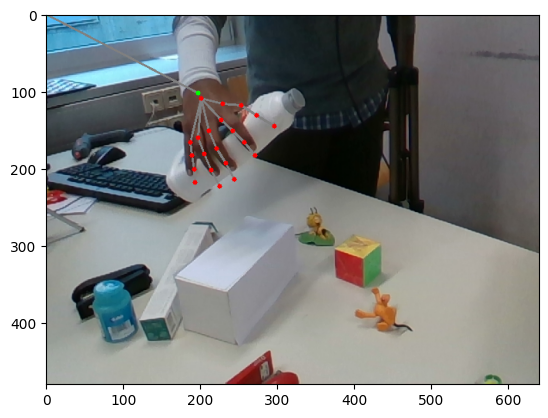

In [22]:
model.phase(Poser.TrainingPhase.INFERENCE)
with torch.inference_mode():
    predict = model(batch)
plt.imshow(predict["logs"]["image"]["img_reproj"][0].permute(1,2,0))

In [ ]:
import kornia.geometry.transform as K

with torch.inference_mode():
    result = model.predict_batch(
        img_tensor=batch["patches"],
        square_bboxes=batch["square_bboxes"],
        timestamp=batch["timestamp"],
        focal=batch["focal"],
        princpt=batch["princpt"]
    )

mpjpe_cs = ((result["joint_cam"] - batch["joint_cam"]) ** 2).sum(-1).sqrt().mean()
mpjpe_rs = (((result["joint_cam"] - result["joint_cam"][:, :, :1]) - (batch["joint_cam"] - batch["joint_cam"][:, :, :1])) ** 2).sum(-1).sqrt().mean()
mpjpe_cs, mpjpe_rs

(tensor(516.9832, device='cuda:0'), tensor(523.6313, device='cuda:0'))